In [89]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import sklearn

import skimage.io
import openslide
import glob
import cv2

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [90]:
INPUT_DIR = "../input/prostate-cancer-grade-assessment/"
TRAIN_IMG_DIR = "../input/prostate-cancer-grade-assessment/train_images/"
TRAIN_MASK_DIR = "../input/prostate-cancer-grade-assessment/train_label_masks/"
TEST_IMG_DIR = "../input/prostate-cancer-grade-assessment/test_images)"

train = pd.read_csv(INPUT_DIR+"train.csv").set_index("image_id")
test = pd.read_csv(INPUT_DIR+"test.csv")
sample_submission = pd.read_csv(INPUT_DIR+"sample_submission.csv")

In [91]:
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [92]:
test.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


## Train data

In [93]:
isup_grade_count = train.isup_grade.value_counts().reset_index()
isup_grade_count.columns = ["isup_grade", "count"]


fig = make_subplots(1,2, specs=[[{"type": "bar"}, {"type": "pie"}]])

colors=px.colors.sequential.Plasma[:6]

fig.add_trace(go.Bar(
        x=isup_grade_count["isup_grade"].values, 
        y=isup_grade_count["count"].values,
        marker=dict(color=colors)
          
), row=1, col=1)

fig.add_trace(go.Pie(
        labels = isup_grade_count["isup_grade"].values,
        values = isup_grade_count["count"].values,
        marker=dict(colors=colors)
), row=1, col=2)

fig.update_layout(title="Isup_grade - Count plots")
fig.show()

In [94]:
karolinska = train.groupby(["data_provider", "isup_grade"])["data_provider"].count().loc["karolinska"].reset_index()
radboud = train.groupby(["data_provider", "isup_grade"])["data_provider"].count().loc["radboud"].reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=karolinska.isup_grade,
    y=karolinska.data_provider,
    name='karolinska',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=radboud.isup_grade,
    y=radboud.data_provider,
    name='rodboud',
    marker_color='lightsalmon'
))

fig.update_layout(title="targets count based on data provider")
fig.show()

**Observation :** Different providers have different target distributions.

In [95]:
gleason_score_count = train.gleason_score.value_counts().reset_index()
gleason_score_count.columns = ["gleason_score", "count"]


fig = make_subplots(1,2, specs=[[{"type": "bar"}, {"type": "pie"}]])

colors=px.colors.sequential.Plotly3

fig.add_trace(go.Bar(
        x=gleason_score_count["gleason_score"].values, 
        y=gleason_score_count["count"].values,
        marker=dict(color=colors)
          
), row=1, col=1)

fig.add_trace(go.Pie(
        labels = gleason_score_count["gleason_score"].values,
        values = gleason_score_count["count"].values,
        marker=dict(colors=colors)
), row=1, col=2)

fig.update_layout(title="Gleason_score - Count plots")
fig.show()

In [96]:
karolinska = train.groupby(["data_provider", "gleason_score"])["data_provider"].count().loc["karolinska"].reset_index()
radboud = train.groupby(["data_provider", "gleason_score"])["data_provider"].count().loc["radboud"].reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=karolinska.gleason_score,
    y=karolinska.data_provider,
    name='karolinska',
    marker_color=px.colors.sequential.Blackbody[1]
))
fig.add_trace(go.Bar(
    x=radboud.gleason_score,
    y=radboud.data_provider,
    name='rodboud',
    marker_color=px.colors.sequential.Blackbody[2]
))

fig.update_layout(title="gleason_score count based on data provider")
fig.show()

In [97]:
path = f"{TRAIN_IMG_DIR}005e66f06bce9c2e49142536caf2f6ee.tiff"
biopsy = openslide.OpenSlide(path)
# do somethiing with the slide hear
biopsy.close()

we created a small function to show some basic information about a slide. Additionally, this function display a small thumbnail of the slide. All images in the dataset contain this metadata and you can use this in your data pipeline.

In [98]:
def print_slide_details(slide, show_thumbnail=True, max_size=(600, 400)):
    """Print some basic information about a slide"""
    # Generate a small image thumbnail
    if show_thumbnail:
        #fig = px.imshow(slide.get_thumbnail(size=max_size))
        #fig.show()
        display(slide.get_thumbnail(size=max_size))
    
    
    # Here we compute the "Pixel spacing" : the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")

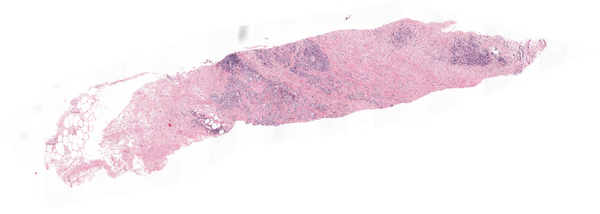

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/ffdc59cd580a1468eac0e6a32dd1ff2d.tiff')
Dimensions: (14336, 5120)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((14336, 5120), (3584, 1280), (896, 320))
ISUP grade: 5
Gleason score: 4+5




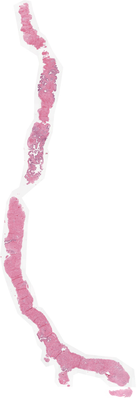

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/ffe06afd66a93258f8fabdef6044e181.tiff')
Dimensions: (9984, 28672)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((9984, 28672), (2496, 7168), (624, 1792))
ISUP grade: 0
Gleason score: negative




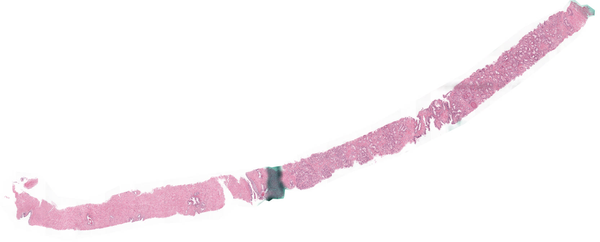

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/ffe236a25d4cbed59438220799920749.tiff')
Dimensions: (26624, 10752)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((26624, 10752), (6656, 2688), (1664, 672))
ISUP grade: 2
Gleason score: 3+4




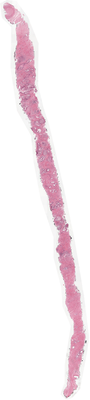

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/ffe9bcababc858e04840669e788065a1.tiff')
Dimensions: (6912, 30720)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((6912, 30720), (1728, 7680), (432, 1920))
ISUP grade: 4
Gleason score: 4+4




In [99]:
example_slides = train.index.values[-4:]

for case_id in example_slides:
    biopsy = openslide.OpenSlide(os.path.join(TRAIN_IMG_DIR, f'{case_id}.tiff'))
    print_slide_details(biopsy)
    biopsy.close()
    
    # Print the case-level label
    print(f"ISUP grade: {train.loc[case_id, 'isup_grade']}")
    print(f"Gleason score: {train.loc[case_id, 'gleason_score']}\n\n")

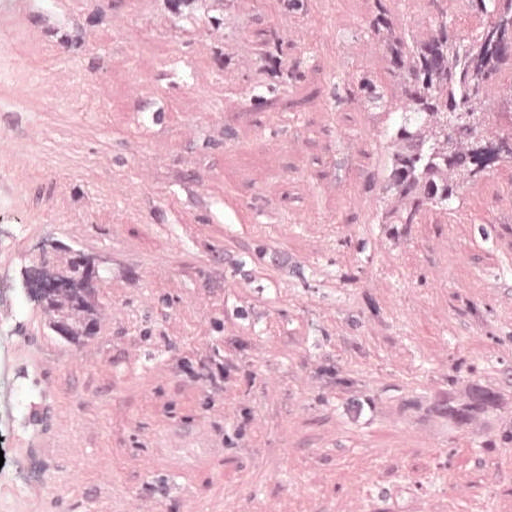

In [100]:
biopsy = openslide.OpenSlide(os.path.join(TRAIN_IMG_DIR, '00928370e2dfeb8a507667ef1d4efcbb.tiff'))

x = 5150
y = 21000
level = 0
width = 512
height = 512

region = biopsy.read_region((x,y), level, (width, height))
#fig = px.imshow(region)
#fig.show()
display(region)

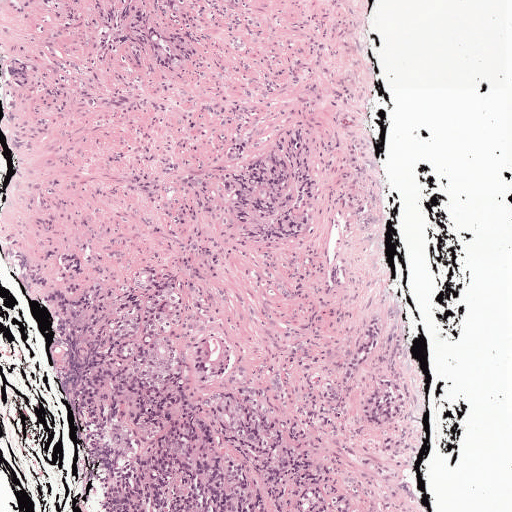

In [101]:
x = 5140
y = 21000
level = 1
width = 512
height = 512

region = biopsy.read_region((x,y), level, (width, height))
#fig = px.imshow(region)
#fig.show()
display(region)

In [102]:
biopsy.close()

In [103]:
def print_mask_details(slide, center='radboud', show_thumbnail=True, max_size=(400,400)):
    """Print some basic information about a slide"""
    
    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")
        
    
    # Generate a small image thumbnail
    if show_thumbnail:
        # Read in the mask data from the highest level
        # We cannot use thumbnail() here because we need to load the raw label data.
        mask_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        # Mask data is present in the R channel
        mask_data = mask_data.split()[0]
        
        # To show the masks we map the raw label values to RGB values
        
        preview_palette = np.zeros(shape=768, dtype=int)
        if center == "radboud":
            # Mapping : {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
            
        elif center == "karolinska":
            
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
            
        mask_data.putpalette(data=preview_palette.tolist())
        mask_data = mask_data.convert(mode='RGB')
        mask_data.thumbnail(size=max_size, resample=0)
        
        #fig = px.imshow(mask_data)
        #fig.show()
        display(mask_data)
        
        # Compute microns per pixel (openslide gives resolution in centimeters)
        spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)

        print(f"File id: {slide}")
        print(f"Dimensions: {slide.dimensions}")
        print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
        print(f"Number of levels in the image: {slide.level_count}")
        print(f"Downsample factor per level: {slide.level_downsamples}")
        print(f"Dimensions of levels: {slide.level_dimensions}")

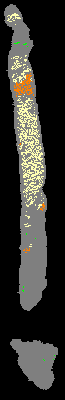

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_label_masks/08ab45297bfe652cc0397f4b37719ba1_mask.tiff')
Dimensions: (3328, 20224)
Microns per pixel / pixel spacing: 0.480
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((3328, 20224), (832, 5056), (208, 1264))


In [104]:
mask = openslide.OpenSlide(os.path.join(TRAIN_MASK_DIR, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
print_mask_details(mask, center='radboud')
mask.close()

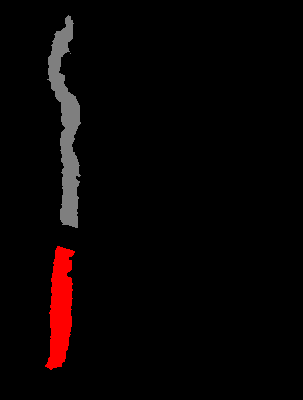

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_label_masks/090a77c517a7a2caa23e443a77a78bc7_mask.tiff')
Dimensions: (19919, 26327)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.000529194200508, 16.00815659848122)
Dimensions of levels: ((19919, 26327), (4979, 6581), (1244, 1645))


In [105]:
mask = openslide.OpenSlide(os.path.join(TRAIN_MASK_DIR, '090a77c517a7a2caa23e443a77a78bc7_mask.tiff'))
print_mask_details(mask, center='karolinska')
mask.close()

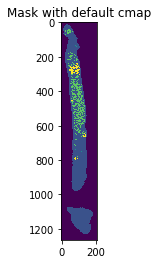

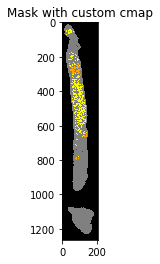

In [106]:
mask = openslide.OpenSlide(os.path.join(TRAIN_MASK_DIR , '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

plt.figure()
plt.title("Mask with default cmap")
plt.imshow(np.asarray(mask_data)[:,:,0], interpolation='nearest')
plt.show()

plt.figure()
plt.title("Mask with custom cmap")
# Optional: create a custom color map
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
plt.show()

mask.close()

# Modeling

In [107]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [108]:
TRAIN_IMG_DIR = "../input/panda2/train_images/"

In [109]:
##%%writefile dataset.py

import pandas as pd
import albumentations
import joblib
import numpy as np
import torch

from PIL import Image

class PANDADatasetTrain:
    def __init__(self, df, img_height, img_width, mean, std, train=True):
        
        self.image_ids = df.index.values
        self.isup_grade = df.isup_grade.values
        self.img_height = img_height
        self.img_width = img_width

        if train:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.ShiftScaleRotate(shift_limit=0.0625,
                                                scale_limit=0.1, 
                                                rotate_limit=5,
                                                p=0.9),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
            


    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = Image.open(f"{TRAIN_IMG_DIR}{self.image_ids[item]}.png")
        #image = image.get_thumbnail(size=(600, 400))
        #print(image.size)
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "image": torch.tensor(image, dtype=torch.float),
            "target": torch.tensor(self.isup_grade[item], dtype=torch.float)
        }

In [110]:
d = PANDADatasetTrain(train, 600, 400, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
out = d.__getitem__(1)
out["image"].shape, out["target"]

(torch.Size([3, 600, 400]), tensor(0.))

In [ ]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
from torch.nn import functional as F

class EfficientNetB1(nn.Module):
    def __init__(self, pretrained):
        super(EfficientNetB1, self).__init__()

        if pretrained is True:
            self.model = EfficientNet.from_pretrained("efficientnet-b1")
        
        self.l0 = nn.Linear(1280, 1)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.extract_features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        out = self.l0(x)

        return out


In [112]:
def criterion(target, output):
    mse_loss = nn.MSELoss()(target, output)
    return torch.sqrt(mse_loss)

def train_model(model, train_loader, epoch, optimizer, scheduler, DEVICE):
    model.train()

    total_loss = 0

    t = tqdm(train_loader)
    for i, d in enumerate(t):

        image = d["image"].float().to(DEVICE)
        target = d["target"].float().to(DEVICE)

        optimizer.zero_grad()

        output = model(image)
        
        #print(output.shape, target.shape)

        loss = criterion(target, output)

        total_loss += loss

        loss.backward()
        optimizer.step()

        #print(total_loss/i+1)
        
        t.set_description(f'Epoch {epoch+1} : Loss: %.4f'%(total_loss/(i+1)))

        #if i % int(t/10) == 0:
        #    print(f'Epoch {epoch+1|i} : Loss: %.4f'%(total_loss/(i+1)))


def valid_model(model, valid_loader, epoch, scheduler, DEVICE):
    model.eval()

    total_loss = 0
    
    output_list = []
    target_list = []

    #t = tqdm(valid_loader)
    with torch.no_grad():
        for i, d in enumerate(valid_loader):

            image = d["image"].float().to(DEVICE)
            target = d["target"].float().to(DEVICE)
            
            output = model(image)

            loss = criterion(target, output)

            total_loss += loss
            
            output = output.squeeze(1)
            output = output.cpu().numpy().tolist()
            target = target.cpu().numpy().tolist()
            
            output_list.extend(output)
            target_list.extend(target)
            

            #if i == 1:
            #    break
        #print(total_loss/i+1)

    RMSE = sklearn.metrics.mean_squared_error(target_list, output_list)
    print(f" Valid RMSE : %.4f"%(RMSE))

    return RMSE

In [113]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
IMG_HEIGHT = 244
IMG_WIDHT = 244
MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)

train_df = train.iloc[:-500]
valid_df = train.iloc[-500:]



train_dataset = PANDADatasetTrain(df=train_df, 
                                  img_height=IMG_HEIGHT,
                                  img_width=IMG_WIDHT,
                                  mean=MODEL_MEAN,
                                  std=MODEL_STD, 
                                  train=True )
    
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size= TRAIN_BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        drop_last=False
    )

valid_dataset = PANDADatasetTrain(df=valid_df, 
                                  img_height=IMG_HEIGHT,
                                  img_width=IMG_WIDHT,
                                  mean=MODEL_MEAN,
                                  std=MODEL_STD, 
                                  train=False)

valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size= VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        drop_last=False
    )

In [ ]:
DEVICE = "cuda"
EPOCHS = 5
start_e = 0

model = ResNet18(pretrained=True)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(start_e, EPOCHS):
    
    train_model(model, train_loader, epoch, optimizer, scheduler=None, DEVICE=DEVICE)
    rmse = valid_model(model, valid_loader, epoch, scheduler=None, DEVICE=DEVICE)
    torch.save(model.state_dict(), f"model_{epoch}_rmse_{rmse}.pth")

In [115]:
def qwk(a1, a2):
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

def quadratic_weighted_kappa(y, y_pred):

    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
        
    conf_mat = confusion_matrix1(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [116]:
# qwk optimize coefficients

class OptimizedRounder(object):
    def __init__(self, init_coef):
        self.init_coef_ = init_coef
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        X_p = X.copy()
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        
        ll = quadratic_weighted_kappa(y, X_p)
        
        return -ll
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        
        initial_coef = self.init_coef_
        
        self.coef_ = spoptimize.minimize(loss_partial, initial_coef, method="nelder-mead")
        
    def predict(self, X, coef):
        X_p = X.copy()
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
                
        return X_p
    
    def coefficients(self):
        return self.coef_['x']